In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from astropy.nddata import block_replicate
from tvtk.api import tvtk, write_data
import pyvista as pv 

import numpy as np
from scipy.integrate import solve_bvp

In [2]:
class PotentialModel(nn.Module):

    def __init__(self, b_n, r_p):
        super().__init__()
        self.register_buffer('b_n', b_n)
        self.register_buffer('r_p', r_p)
        c = np.zeros((1, 3))
        c[:, 2] = (1 / np.sqrt(2 * np.pi))
        c = torch.tensor(c, dtype=torch.float32, )
        self.register_buffer('c', c)

    def forward(self, coord):
        v1 = self.b_n[:, None]
        v2 = 2 * np.pi * ((-self.r_p[:, None] + coord[None, :] + self.c[None]) ** 2).sum(-1) ** 0.5
        potential = torch.sum(v1 / v2, dim=0)
        return potential
    
def get_potential(b_n, height, batch_size=2048, strides=(1, 1, 1), progress=True):
    cube_shape = (*b_n.shape, height)
    strides = (strides, strides, strides) if isinstance(strides, int) else strides
    b_n = b_n.reshape((-1,)).astype(np.float32)
    coords = np.stack(np.mgrid[:cube_shape[0]:strides[0], :cube_shape[1]:strides[1], :cube_shape[2]:strides[2]], -1).reshape((-1, 3))
    r_p = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], :1], -1).reshape((-1, 3))

    # torch code
    # r = (x * y, 3); coords = (x*y*z, 3), c = (1, 3)
    # --> (x * y, x * y * z, 3) --> (x * y, x * y * z) --> (x * y * z)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
        b_n = torch.tensor(b_n, dtype=torch.float32, )
        r_p = torch.tensor(r_p, dtype=torch.float32, )
        model = nn.DataParallel(PotentialModel(b_n, r_p)).to(device)

        coords = torch.tensor(coords, dtype=torch.float32)
        potential = []
        loader = DataLoader(TensorDataset(coords), batch_size=batch_size, num_workers=8)
        it = tqdm(loader, desc='Potential Field') if progress else loader
        for coord, in it:
            coord = coord.to(device)
            p_batch = model(coord)
            potential += [p_batch]

    potential = torch.cat(potential).view(cube_shape).cpu().numpy()
    if strides != (1, 1, 1):
        potential = block_replicate(potential, strides, conserve_sum=False)
    return potential

In [3]:
def divergence(b_field):  # (x, y, z, (xyz-field))
    div_B = np.stack([np.gradient(b_field[..., i], axis=i, edge_order=2) for i in range(3)], axis=-1).sum(-1)
    return div_B


def curl(b_field):  # (x, y, z)
    _, dFx_dy, dFx_dz = np.gradient(b_field[..., 0], axis=[0, 1, 2], edge_order=2)
    dFy_dx, _, dFy_dz = np.gradient(b_field[..., 1], axis=[0, 1, 2], edge_order=2)
    dFz_dx, dFz_dy, _ = np.gradient(b_field[..., 2], axis=[0, 1, 2], edge_order=2)

    rot_x = dFz_dy - dFy_dz
    rot_y = dFx_dz - dFz_dx
    rot_z = dFy_dx - dFx_dy

    return np.stack([rot_x, rot_y, rot_z], -1)


def lorentz_force(b_field, j_field=None):
    j_field = j_field if j_field is not None else curl(b_field)
    l = np.cross(j_field, b_field, axis=-1)
    return l


def vector_norm(vector):
    return np.sqrt((vector ** 2).sum(-1))


def angle(b_field, j_field):
    norm = vector_norm(b_field) * vector_norm(j_field) + 1e-7
    j_cross_b = np.cross(j_field, b_field, axis=-1)
    sig = vector_norm(j_cross_b) / norm
    return np.arcsin(np.clip(sig, -1. + 1e-7, 1. - 1e-7)) * (180 / np.pi)


def normalized_divergence(b_field):
    return np.abs(divergence(b_field)) / (vector_norm(b_field) + 1e-7)


def weighted_sigma(b, j=None):
    j = j if j is not None else curl(b)
    sigma = vector_norm(lorentz_force(b, j)) / vector_norm(b) / vector_norm(j)
    w_sigma = np.average((sigma), weights=vector_norm(j))
    theta_j = np.arcsin(w_sigma) * (180 / np.pi)
    return theta_j


def energy(b):
    return (b ** 2).sum(-1) / (8 * np.pi)

In [4]:
def get_analytic_b_field(n=1, m=1, l=0.3, psi=np.pi / 4, resolution=64, bounds=[-1, 1, -1, 1, 0, 2]):
    """
    Calculate the analytic NLFF field from Low & Lou (1989).

    :param n: variable see Low & Lou (1989), only works for n=1
    :param m: used for generating a proper initial condition.
    :param a2: eigenvalue
    :param l: depth below the photosphere
    :param psi: angle of the magnetic field relative to the dipol axis
    :param resolution: spatial resolution of the magnetic field in pixels
    :param bounds: dimensions of the volume (x_start, x_end, y_start, y_end, z_start, z_end)
    :return: magnetic field B (x, y, z, v)
    """
    sol_P, a2 = solve_P(n, m)

    resolution = [resolution] * 3 if not isinstance(resolution, list) else resolution
    coords = np.stack(np.meshgrid(np.linspace(bounds[0], bounds[1], resolution[1], dtype=np.float32),
                                  np.linspace(bounds[2], bounds[3], resolution[0], dtype=np.float32),
                                  np.linspace(bounds[4], bounds[5], resolution[2], dtype=np.float32)), -1).transpose(
        [1, 0, 2, 3])

    x, y, z = coords[..., 0], coords[..., 1], coords[..., 2]
    X = x * np.cos(psi) - (z + l) * np.sin(psi)
    Y = y
    Z = x * np.sin(psi) + (z + l) * np.cos(psi)

    # to spherical coordinates
    xy = X ** 2 + Y ** 2
    r = np.sqrt(xy + Z ** 2)
    theta = np.arctan2(np.sqrt(xy), Z)
    phi = np.arctan2(Y, X)

    mu = np.cos(theta)

    P, dP_dmu = sol_P(mu)
    A = P / r ** n
    dA_dtheta = -np.sin(theta) / (r ** n) * dP_dmu
    dA_dr = P * (-n * r ** (-n - 1))
    Q = np.sqrt(a2) * A * np.abs(A) ** (1 / n)

    Br = (r ** 2 * np.sin(theta)) ** -1 * dA_dtheta
    Btheta = - (r * np.sin(theta)) ** -1 * dA_dr
    Bphi = (r * np.sin(theta)) ** -1 * Q

    BX = Br * np.sin(theta) * np.cos(phi) + Btheta * np.cos(theta) * np.cos(phi) - Bphi * np.sin(phi)
    BY = Br * np.sin(theta) * np.sin(phi) + Btheta * np.cos(theta) * np.sin(phi) + Bphi * np.cos(phi)
    BZ = Br * np.cos(theta) - Btheta * np.sin(theta)

    Bx = BX * np.cos(psi) + BZ * np.sin(psi)
    By = BY
    Bz = - BX * np.sin(psi) + BZ * np.cos(psi)

    b_field = np.real(np.stack([Bx, By, Bz], -1))
    return b_field


def solve_P(n, m):
    """
    Solve the differential equation from Low & Lou (1989).

    :param n: variable (only n=1)
    :param v0: start condition for dP/dmu
    :param P0: boundary condition for P(-1) and P(1)
    :return: interpolated functions for P and dP/dmu
    """

    def f(x, y, p):
        a2 = p[0]
        d2P_dmu2 = -(n * (n + 1) * y[0] + a2 * (1 + n) / n * y[0] ** (1 + 2 / n)) / (1 - x ** 2 + 1e-6)
        return [y[1], d2P_dmu2]

    def f_boundary(Pa, Pb, p):
        return np.array([Pa[0] - 0, Pb[0] - 0, Pa[1] - 10])

    mu = np.linspace(-1, 1, num=256)

    if m % 2 == 0:
        init = np.cos(mu * (m + 1) * np.pi / 2)
    else:
        init = np.sin(mu * (m + 1) * np.pi / 2)

    dinit = 10 * np.ones_like(init)  #
    initial = np.stack([init, dinit])

    @np.vectorize
    def shooting(a2_init):
        eval = solve_bvp(f, f_boundary, x=mu, y=initial, p=[a2_init], verbose=0, tol=1e-6)
        if eval.success == False:
            return None
        return eval

    # use shooting to find eigenvalues
    evals = shooting(np.linspace(0, 10, 100, dtype=np.float32))
    evals = [e for e in evals if e is not None]

    eigenvalues = np.array([e.p for e in evals])
    eigenvalues = sorted(set(np.round(eigenvalues, 4).reshape((-1,))))

    # get final solution
    eval = shooting([eigenvalues[-1]])[0]

    return eval.sol, eval.p[0]

In [5]:
B = get_analytic_b_field(n = 1, m = 1, l=0.3, psi=np.pi/3, resolution=[80, 80, 72])

In [6]:
B.shape

(80, 80, 72, 3)

In [7]:
b = B

# for CASE 2 crop central 64^3
B = B[8:-8, 8:-8, :64]
b = b[8:-8, 8:-8, :64]

c_vec = np.sum((B * b).sum(-1)) / np.sqrt((B ** 2).sum(-1).sum() * (b ** 2).sum(-1).sum())
M = np.prod(B.shape[:-1])
c_cs = 1 / M * np.sum((B * b).sum(-1) / vector_norm(B) / vector_norm(b))

E_n = vector_norm(b - B).sum() / vector_norm(B).sum()

E_m = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()

eps = (vector_norm(b) ** 2).sum() / (vector_norm(B) ** 2).sum()

B_potential = get_potential(B[:, :, 0, 2], 64)

eps_p = (vector_norm(b) ** 2).sum() / (vector_norm(B_potential) ** 2).sum()
eps_p_ll = (vector_norm(B) ** 2).sum() / (vector_norm(B_potential) ** 2).sum()

j = curl(b)
sig_J = (vector_norm(np.cross(j, b, -1)) / vector_norm(b)).sum() / vector_norm(j).sum()

L1 = (vector_norm(np.cross(j, b, -1)) ** 2 / vector_norm(b) ** 2).mean()
L2 = (divergence(b) ** 2).mean()

L1_B = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()
L2_B = (divergence(B) ** 2).mean()

base_path = './'
with open(f'{base_path}/evaluation.txt', 'w') as f:
    print('c_vec', c_vec, file=f)
    print('c_cs', c_cs, file=f)
    print('E_n', 1 - E_n, file=f)
    print('E_m', 1 - E_m, file=f)
    print('eps', eps, file=f)
    print('eps_P', eps_p, file=f)
    print('eps_P_LL', eps_p_ll, file=f)
    print('sig_J * 1e2', sig_J * 1e2, file=f)
    print('L1', L1, file=f)
    print('L2', L2, file=f)
    print('L1_B', L1_B, file=f)
    print('L2_B', L2_B, file=f)

Potential Field: 100%|██████████| 128/128 [00:01<00:00, 90.81it/s] 


In [8]:
vtk_path = './evaluation.vtk'
dim = b.shape[:-1]
pts = np.stack(np.mgrid[0:dim[0], 0:dim[1], 0:dim[2]], -1).astype(np.float32)
pts = pts.transpose(2, 1, 0, 3)
pts = pts.reshape((-1, 3))
vectors = b.transpose(2, 1, 0, 3)
vectors = vectors.reshape((-1, 3))
sg = tvtk.StructuredGrid(dimensions=dim, points=pts)
sg.point_data.vectors = vectors
sg.point_data.vectors.name = 'B'
write_data(sg, str(vtk_path))

In [9]:
mesh = pv.read(vtk_path)
mesh

StructuredGrid (0x7fbc1c7b2b60)
  N Cells:      250047
  N Points:     262144
  X Bounds:     0.000e+00, 6.300e+01
  Y Bounds:     0.000e+00, 6.300e+01
  Z Bounds:     0.000e+00, 6.300e+01
  Dimensions:   64, 64, 64
  N Arrays:     1

In [10]:
xindmax, yindmax, zindmax = mesh.dimensions
xcenter, ycenter, zcenter = mesh.center

mesh_g = mesh.compute_derivative(scalars='B')

def gradients_to_dict(arr):
    keys = np.array(
        ["dBx/dx", "dBx/dy", "dBx/dz", "dBy/dx", "dBy/dy", "dBy/dz", "dBz/dx", "dBz/dy", "dBz/dz"]
    )
    keys = keys.reshape((3,3))[:, : arr.shape[1]].ravel()
    return dict(zip(keys, mesh_g['gradient'].T))

gradients = gradients_to_dict(mesh_g['gradient'])

curlB_x = gradients['dBz/dy'] - gradients['dBy/dz']
curlB_y = gradients['dBx/dz'] - gradients['dBz/dx']
curlB_z = gradients['dBy/dx'] - gradients['dBx/dy']

curlB = np.vstack([curlB_x, curlB_y, curlB_z]).T

mesh.point_data['curlB'] = curlB
mesh

StructuredGrid (0x7fbc1c7b2b60)
  N Cells:      250047
  N Points:     262144
  X Bounds:     0.000e+00, 6.300e+01
  Y Bounds:     0.000e+00, 6.300e+01
  Z Bounds:     0.000e+00, 6.300e+01
  Dimensions:   64, 64, 64
  N Arrays:     2

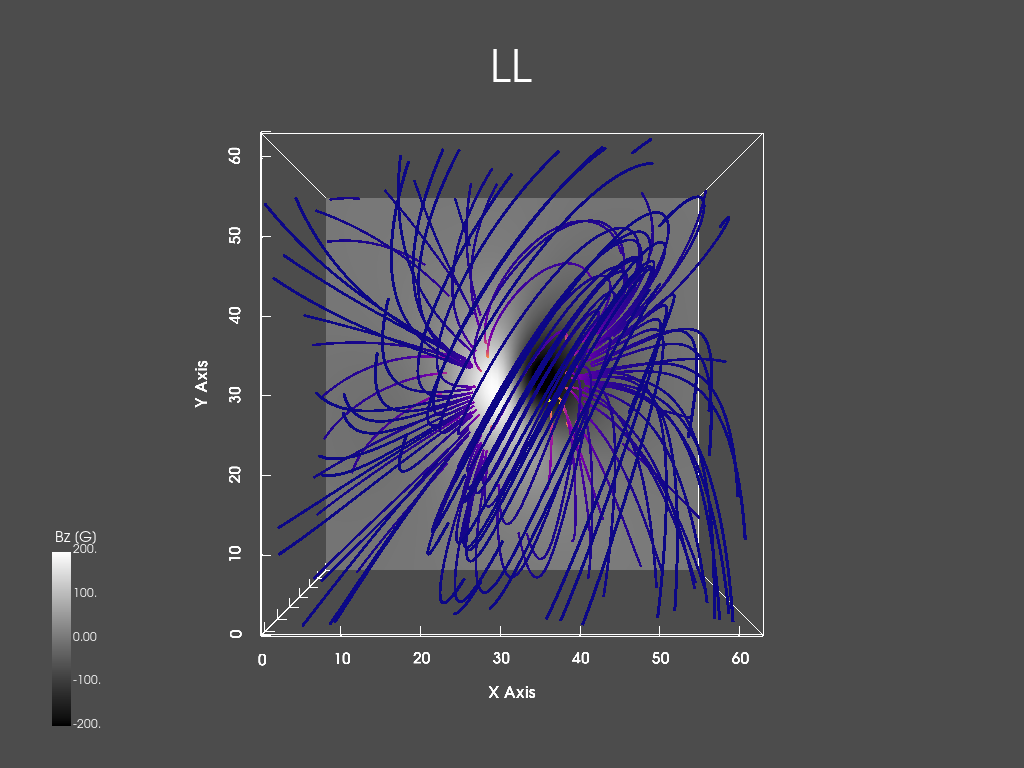

In [11]:
p = pv.Plotter()
p.add_mesh(mesh.outline())

#-----------------------
sargs_B = dict(
    title='Bz [G]',
    title_font_size=15,
    height=0.25,
    width=0.05,
    vertical=True,
    position_x = 0.05,
    position_y = 0.05,
)
dargs_B = dict(
    scalars='B', 
    component=2, 
    clim=(-200, 200), 
    scalar_bar_args=sargs_B, 
    show_scalar_bar=True, 
    lighting=False
)
p.add_mesh(mesh.extract_subset((0, xindmax, 0, yindmax, 0, 0)), 
           cmap='gray', **dargs_B)
#-----------------------

#-----------------------
sargs_J = dict(
    title='J = curl(B)',
    title_font_size=15,
    height=0.25,
    width=0.05,
    vertical=True,
    position_x = 0.9,
    position_y = 0.05,
)
dargs_J = dict(
    scalars='curlB', 
    clim=(0, 20),
    scalar_bar_args=sargs_J, 
    show_scalar_bar=False, 
    lighting=False
)
#-----------------------

def draw_streamlines(pts):
    stream, src = mesh.streamlines(
        return_source=True,
        # source_center=(120, 90, 0),
        # source_radius=5,
        # n_points=100,
        start_position = pts,
        integration_direction='both',
        # progress_bar=False,
        max_time=1000,
        # initial_step_length=0.001,
        # min_step_length=0.001,
        # max_step_length=2.0,
        # max_steps=999999,
        # terminal_speed = 1e-16,
        # max_error = 1e-6,
    )
    p.add_mesh(stream.tube(radius=0.2), 
            cmap='plasma', **dargs_J)

# for i in np.arange(xcenter-5, xcenter, 1):
#     for j in np.arange(ycenter-5, ycenter, 1):
#         try: 
#             draw_streamlines((i, j, 0))
#         except:
#             print(i, j)

stream, src = mesh.streamlines(
        return_source=True,
        # source_center=(120, 90, 0),
        source_radius=64,
        n_points=500,
        # start_position = pts,
        integration_direction='both',
        # progress_bar=False,
        max_time=1000,
        # initial_step_length=0.001,
        # min_step_length=0.001,
        # max_step_length=2.0,
        # max_steps=999999,
        # terminal_speed = 1e-16,
        # max_error = 1e-6,
    )
p.add_mesh(stream.tube(radius=0.2), 
        cmap='plasma', **dargs_J)

p.camera_position = 'xy'           
# p.camera.azimuth = -100
# p.camera.elevation = -20
# p.camera.zoom(1.0)
p.show_bounds()
p.add_title('LL')
p.show(jupyter_backend='static')